In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')
len(df)

20640

In [3]:
df[:5]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
df = df.fillna(0)
df.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [6]:
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']
df[:5]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.984127,0.146591,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.238137,0.155797,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,8.288136,0.129516,2.802260
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,5.817352,0.184458,2.547945
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,6.281853,0.172096,2.181467


In [7]:
df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
np.random.seed(42)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy().reset_index(drop=True)
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy().reset_index(drop=True)
df_test = df_shuffled.iloc[n_train:].copy().reset_index(drop=True)

y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_test_orig = df_test.median_house_value.values

y_train = df_train.median_house_value
y_val = df_val.median_house_value
y_test = df_test.median_house_value

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

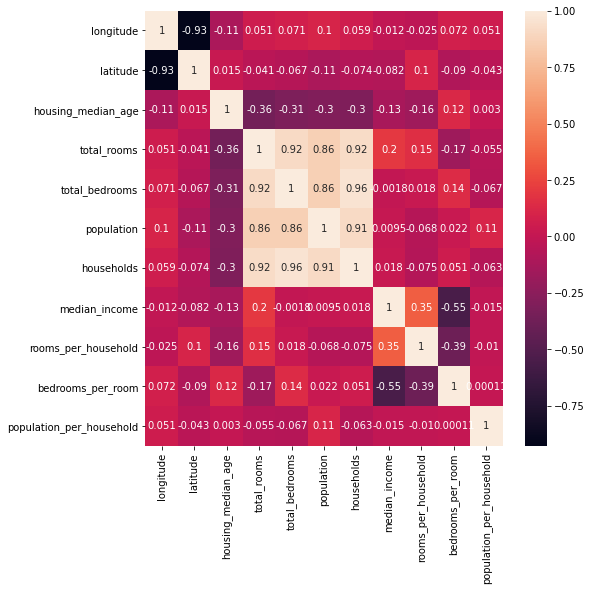

In [9]:
plt.figure(figsize = (8,8))
corrmatrix = df_train.corr()
#print (corrMatrix)
sns.heatmap(corrmatrix, annot=True)
plt.show()

In [10]:
y_train_above_average = y_train > y_train.mean()
y_train_above_average = (y_train_above_average == True).astype(int)

y_val_above_average = y_val > y_val.mean()
y_val_above_average = (y_val_above_average == True).astype(int)

y_test_above_average = y_test > y_test.mean()
y_test_above_average = (y_test_above_average == True).astype(int)

In [11]:
def calculate_mi(series):
    return mutual_info_score(series, y_train_above_average)

#df_mi = df_train['ocean_proximity'].apply(calculate_mi)
df_mi = calculate_mi(df_train['ocean_proximity'])
#df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')
round(df_mi, 2)

0.1

In [12]:
train_dict = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, 
    max_iter=1000, random_state=42)
model.fit(X_train, y_train_above_average)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [13]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]
round(accuracy_score(y_val_above_average, y_pred >= 0.5), 2)

0.83

In [18]:
subset = ['total_rooms', 'total_bedrooms', 
    'population', 'households']

train_dict_small = df_train[subset].to_dict(orient='records')

dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

X_small = dv_small.transform(train_dict_small)

model_rooms = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model_rooms.fit(X_small, y_train_above_average)

val_dict = df_val[subset].to_dict(orient='records')
X_val = dv_small.transform(val_dict)
y_pred = model_rooms.predict_proba(X_val)[:, 1]

round(accuracy_score(y_val_above_average, y_pred >= 0.5), 2)

0.69

In [19]:
rooms_subset = ['total_bedrooms', 
    'population', 'households']

train_dict_small = df_train[rooms_subset].to_dict(orient='records')

dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

X_small_rooms = dv_small.transform(train_dict_small)

model_rooms = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model_rooms.fit(X_small_rooms, y_train_above_average)

val_dict = df_val[rooms_subset].to_dict(orient='records')
X_val = dv_small.transform(val_dict)
y_pred = model_rooms.predict_proba(X_val)[:, 1]

round(accuracy_score(y_val_above_average, y_pred >= 0.5), 2)

0.62

In [20]:
bedrooms_subset = ['total_rooms', 
    'population', 'households']

train_dict_small = df_train[rooms_subset].to_dict(orient='records')

dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

X_small_rooms = dv_small.transform(train_dict_small)

model_small = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model_small.fit(X_small_rooms, y_train_above_average)

val_dict = df_val[bedrooms_subset].to_dict(orient='records')
X_val = dv_small.transform(val_dict)
y_pred = model_small.predict_proba(X_val)[:, 1]

round(accuracy_score(y_val_above_average, y_pred >= 0.5), 2)

0.57

In [24]:
pop_subset = ['total_rooms', 'total_bedrooms', 
    'population',]

train_dict_small = df_train[pop_subset].to_dict(orient='records')

dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

X_small_pop = dv_small.transform(train_dict_small)

model_small = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model_small.fit(X_small_pop, y_train_above_average)

val_dict = df_val[pop_subset].to_dict(orient='records')
X_val = dv_small.transform(val_dict)
y_pred = model_small.predict_proba(X_val)[:, 1]

round(accuracy_score(y_val_above_average, y_pred >= 0.5), 2)

0.67

In [25]:
house_subset = ['total_rooms', 'total_bedrooms', 
    'population',]

train_dict_small = df_train[house_subset].to_dict(orient='records')

dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

X_small_house = dv_small.transform(train_dict_small)

model_small = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model_small.fit(X_small_house, y_train_above_average)

val_dict = df_val[house_subset].to_dict(orient='records')
X_val = dv_small.transform(val_dict)
y_pred = model_small.predict_proba(X_val)[:, 1]

round(accuracy_score(y_val_above_average, y_pred >= 0.5), 2)

0.67

In [35]:
np.random.seed(42)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy().reset_index(drop=True)
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy().reset_index(drop=True)
df_test = df_shuffled.iloc[n_train:].copy().reset_index(drop=True)

y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_test_orig = df_test.median_house_value.values

y_train = np.log1p(df_train.median_house_value)
y_val = np.log1p(df_val.median_house_value)
y_test = np.log1p(df_test.median_house_value)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [37]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [38]:
train_dict = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)

for i in [0, 0.01, 0.1, 1, 10]:
    model = Ridge(alpha = i, solver='sag', random_state=42)
    model.fit(X_train, y_train)

    val_dict = df_val.to_dict(orient='records')
    X_val = dv.transform(val_dict)
    y_pred = model.predict(X_val)
    #acc = round(accuracy_score(y_val, y_pred), 2)
    rms = round(rmse(y_val, y_pred), 3)
    print('alpha: {} has an rmse score of {}.'.format(i, rms))

alpha: 0 has an rmse score of 0.529.
alpha: 0.01 has an rmse score of 0.529.
alpha: 0.1 has an rmse score of 0.529.
alpha: 1 has an rmse score of 0.529.
alpha: 10 has an rmse score of 0.529.


In [39]:
df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
0,-119.01,36.06,25.0,1505.0,0.0,1392.0,359.0,1.6812,INLAND,4.192201,0.0,3.877437
1,-119.46,35.14,30.0,2943.0,0.0,1565.0,584.0,2.5313,INLAND,5.039384,0.0,2.679795
2,-122.44,37.80,52.0,3830.0,0.0,1310.0,963.0,3.4801,NEAR BAY,3.977155,0.0,1.360332
3,-118.72,34.28,17.0,3051.0,0.0,1705.0,495.0,5.7376,<1H OCEAN,6.163636,0.0,3.444444
4,-121.93,36.62,34.0,2351.0,0.0,1063.0,428.0,3.7250,NEAR OCEAN,5.492991,0.0,2.483645
